https://huggingface.co/Alia-Mohammed/resnet-50-finetuned-brain-tumor

In [12]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


In [13]:
# Define the data directories
normal_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Normal'
hemorrhage_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Hemorrhage'
# Get the list of all the images
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
hemorrhage_images = [os.path.join(hemorrhage_dir, img) for img in os.listdir(hemorrhage_dir)]
# Create labels
normal_labels = [0]*len(normal_images)  # let's assume 0 for normal
hemorrhage_labels = [1]*len(hemorrhage_images)  # and 1 for hemorrhage

# Concatenate data and labels
images = normal_images + hemorrhage_images
labels = normal_labels + hemorrhage_labels


PyTorch uses a Dataset object, which is an abstract class representing a dataset, and a DataLoader, which wraps an iterable around the Dataset. Here's how you can create a custom Dataset for your images:

In [14]:
from torch.utils.data import Dataset
from PIL import Image
import albumentations as albu
from albumentations.pytorch import ToTensorV2

HFLIP = 'T'  # Or 'F', based on your requirement
HFLIPVAL = 1.0 if HFLIP == 'T' else 0.0

class BrainCTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            # Since albumentations requires numpy arrays, convert the image to a numpy array first
            image_np = np.array(image)
            augmented = self.transform(image=image_np)
            image = augmented['image']

        return image, label

# Transformations using albumentations
data_transforms = {
    'train': albu.Compose([
        albu.RandomResizedCrop(height=224, width=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333), p=1.0),
        albu.HorizontalFlip(p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.Rotate(limit=20),  # Random rotation between -20 and 20 degrees
        albu.GaussianBlur(p=0.3),
        albu.HueSaturationValue(p=0.3),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
    'val': albu.Compose([
        albu.Resize(height=256, width=256),
        albu.CenterCrop(height=224, width=224),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
    'test': albu.Compose([   # Generally, you don't augment test data. Just resize and normalize.
        albu.Resize(height=256, width=256),
        albu.CenterCrop(height=224, width=224),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
}

# Split the data into training, validation, and test sets
train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels, test_size=0.3, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42)

# Create the datasets
train_dataset = BrainCTDataset(train_images, train_labels, transform=data_transforms['train'])
val_dataset = BrainCTDataset(val_images, val_labels, transform=data_transforms['val'])
test_dataset = BrainCTDataset(test_images, test_labels, transform=data_transforms['test'])


# Create the dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'valid': DataLoader(val_dataset, batch_size=32, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False)
}

print(f"Number of train images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")


Number of train images: 4167
Number of validation images: 893
Number of test images: 893


Training Images:


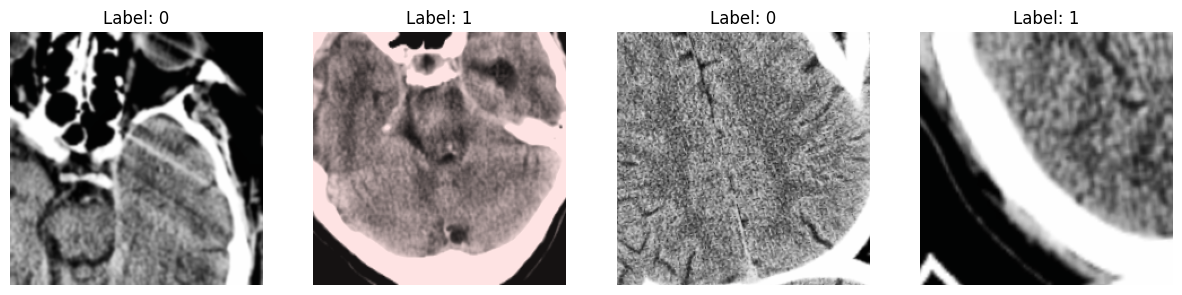

Validation Images:


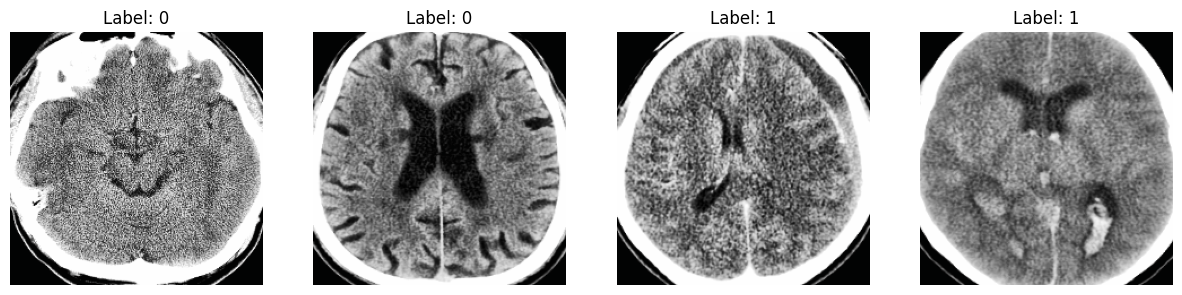

In [15]:
def visualize_random_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,5))

    for index,image in enumerate(images[:num_images]):
        plt.subplot(1, num_images,index+1)
        # Unnormalize and display the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[index].item()}")
        plt.axis("off")
    plt.show()

# Visualize random images from training dataset
print("Training Images:")
visualize_random_images(dataloaders['train'])

# Visualize random images from validation dataset
print("Validation Images:")
visualize_random_images(dataloaders['valid'])


## feature extraction Resnet50 brain-tumor fineTuned


In [25]:
from transformers import AutoConfig, AutoModel


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Load configuration and model
config = AutoConfig.from_pretrained(r'C:\LMS\8\project\Medical student\CQ500_data\models\resnet-50-finetuned-brain-tumor')
model = AutoModel.from_pretrained(r'C:\LMS\8\project\Medical student\CQ500_data\models\resnet-50-finetuned-brain-tumor', config=config)

for param in model.parameters():
    param.requires_grad = False

model

cuda:0


ResNetModel(
  (embedder): ResNetEmbeddings(
    (embedder): ResNetConvLayer(
      (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder): ResNetEncoder(
    (stages): ModuleList(
      (0): ResNetStage(
        (layers): Sequential(
          (0): ResNetBottleNeckLayer(
            (shortcut): ResNetShortCut(
              (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (layer): Sequential(
              (0): ResNetConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalizatio

In [26]:

# Replace the classifier
# model.fc = nn.Sequential(
#     nn.Linear(100352, 512),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(512, 2),
# )

model.classification_layer = nn.Linear(2048*7*7,2)

model = model.to(device)


In [27]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
ResNetModel                                                  --
├─ResNetEmbeddings: 1-1                                      --
│    └─ResNetConvLayer: 2-1                                  --
│    │    └─Conv2d: 3-1                                      (9,408)
│    │    └─BatchNorm2d: 3-2                                 (128)
│    │    └─ReLU: 3-3                                        --
│    └─MaxPool2d: 2-2                                        --
├─ResNetEncoder: 1-2                                         --
│    └─ModuleList: 2-3                                       --
│    │    └─ResNetStage: 3-4                                 (215,808)
│    │    └─ResNetStage: 3-5                                 (1,219,584)
│    │    └─ResNetStage: 3-6                                 (7,098,368)
│    │    └─ResNetStage: 3-7                                 (14,964,736)
├─AdaptiveAvgPool2d: 1-3                                

In [28]:
import time
import copy
from tqdm.auto import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Here we will save the metrics
    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    dataset_sizes = {
        'train': len(train_dataset),
        'valid': len(val_dataset)
    }

    for epoch in tqdm(range(1, num_epochs+1)):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.long()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    model_outputs = model(inputs)
                    


                    outputs = model(inputs).last_hidden_state
                    
                    # Reshape the output tensor
                    outputs = outputs.view(outputs.size(0), -1)  # If your output is [32, 2048, 7, 7], this reshapes the tensor to [32, 2048*7*7]

                    # Pass through the classification layer (assuming you have defined model.fc as your classifier)
                    logits = model.classification_layer(outputs)
                    
                    # Compute predictions
                    _, preds = torch.max(logits, 1)
                    
                    # Compute the loss
                    loss = criterion(logits, labels)
                                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Store the loss and accuracy values
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [29]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.classification_layer.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=20)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
----------
train Loss: 1.5218 Acc: 0.5644


  5%|▌         | 1/20 [00:37<11:46, 37.21s/it]

valid Loss: 1.4879 Acc: 0.6316

Epoch 2/20
----------
train Loss: 1.8678 Acc: 0.5721


 10%|█         | 2/20 [01:07<09:55, 33.09s/it]

valid Loss: 1.5451 Acc: 0.5946

Epoch 3/20
----------
train Loss: 2.0592 Acc: 0.5856


 15%|█▌        | 3/20 [01:36<08:50, 31.23s/it]

valid Loss: 1.7162 Acc: 0.5689

Epoch 4/20
----------
train Loss: 2.0395 Acc: 0.5928


 20%|██        | 4/20 [02:05<08:04, 30.28s/it]

valid Loss: 1.8296 Acc: 0.6372

Epoch 5/20
----------
train Loss: 1.9925 Acc: 0.5995


 25%|██▌       | 5/20 [02:35<07:32, 30.16s/it]

valid Loss: 1.8310 Acc: 0.6697

Epoch 6/20
----------
train Loss: 2.1555 Acc: 0.5947


 30%|███       | 6/20 [03:05<07:01, 30.08s/it]

valid Loss: 2.6096 Acc: 0.5286

Epoch 7/20
----------
train Loss: 2.1699 Acc: 0.6134


 35%|███▌      | 7/20 [03:35<06:30, 30.06s/it]

valid Loss: 2.0044 Acc: 0.5789

Epoch 8/20
----------
train Loss: 2.3485 Acc: 0.6002


 40%|████      | 8/20 [04:06<06:06, 30.52s/it]

valid Loss: 2.1932 Acc: 0.6753

Epoch 9/20
----------
train Loss: 2.3392 Acc: 0.6052


 45%|████▌     | 9/20 [04:36<05:35, 30.46s/it]

valid Loss: 2.0928 Acc: 0.6741

Epoch 10/20
----------
train Loss: 2.4501 Acc: 0.6122


 50%|█████     | 10/20 [05:07<05:03, 30.36s/it]

valid Loss: 2.3325 Acc: 0.5745

Epoch 11/20
----------
train Loss: 2.5386 Acc: 0.6144


 55%|█████▌    | 11/20 [05:36<04:31, 30.14s/it]

valid Loss: 2.3407 Acc: 0.6775

Epoch 12/20
----------
train Loss: 2.4770 Acc: 0.6132


 60%|██████    | 12/20 [06:05<03:58, 29.77s/it]

valid Loss: 2.2096 Acc: 0.5924

Epoch 13/20
----------
train Loss: 2.6160 Acc: 0.6050


 65%|██████▌   | 13/20 [06:35<03:28, 29.84s/it]

valid Loss: 2.1019 Acc: 0.6193

Epoch 14/20
----------
train Loss: 2.5405 Acc: 0.6182


 70%|███████   | 14/20 [07:06<03:00, 30.14s/it]

valid Loss: 3.5265 Acc: 0.6719

Epoch 15/20
----------
train Loss: 2.4803 Acc: 0.6141


 75%|███████▌  | 15/20 [07:37<02:31, 30.29s/it]

valid Loss: 2.1735 Acc: 0.6305

Epoch 16/20
----------
train Loss: 2.5799 Acc: 0.6028


 80%|████████  | 16/20 [08:07<02:01, 30.41s/it]

valid Loss: 2.5516 Acc: 0.6697

Epoch 17/20
----------
train Loss: 2.5994 Acc: 0.6199


 85%|████████▌ | 17/20 [08:39<01:32, 30.68s/it]

valid Loss: 2.2605 Acc: 0.6719

Epoch 18/20
----------
train Loss: 2.7443 Acc: 0.5971


 90%|█████████ | 18/20 [09:10<01:01, 30.95s/it]

valid Loss: 2.2583 Acc: 0.6439

Epoch 19/20
----------
train Loss: 2.6117 Acc: 0.6100


 95%|█████████▌| 19/20 [09:41<00:31, 31.01s/it]

valid Loss: 2.0087 Acc: 0.6540

Epoch 20/20
----------
train Loss: 2.8101 Acc: 0.6093


100%|██████████| 20/20 [10:13<00:00, 30.66s/it]

valid Loss: 2.3304 Acc: 0.6573

Training complete in 10m 13s
Best valid accuracy: 0.677492


In [34]:
# Switch to evaluation mode
model.eval()

# Initialize the prediction and label lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')


with torch.no_grad():

    print("Preds shape:", preds.shape)
    print("Classes shape:", classes.shape)

    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        logits = outputs[0]
        _, preds = torch.max(logits, 1)
        print(outputs)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat)

# Compute the classification report
from sklearn.metrics import classification_report
class_report=classification_report(lbllist.numpy(), predlist.numpy())
print('Classification Report')
print('-'*20)
print(class_report)


Preds shape: torch.Size([29, 7, 7])
Classes shape: torch.Size([29])
BaseModelOutputWithPoolingAndNoAttention(last_hidden_state=tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.1514e-01,
           1.0382e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 3.6169e-01,  ..., 7.7157e-01,
           3.4545e-01, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 1.0956e+00,  ..., 0.0000e+00,
           1.4481e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  

ValueError: Found input variables with inconsistent numbers of samples: [893, 43757]

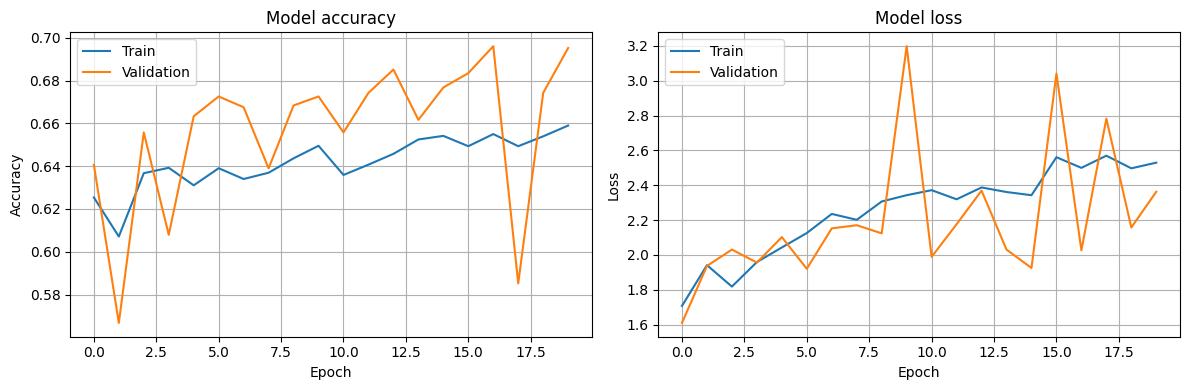

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # plot training and validation accuracy values
    ax1.plot(history['train_acc'], label='Train')
    ax1.plot(history['valid_acc'], label='Validation')
    ax1.set_title("Model accuracy")
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # plot training and validation loss values
    ax2.plot(history['train_loss'], label='Train')
    ax2.plot(history['valid_loss'], label='Validation')
    ax2.set_title("Model loss")
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
model.state_dict()